# EX_01

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm 
import numpy as np

print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: False


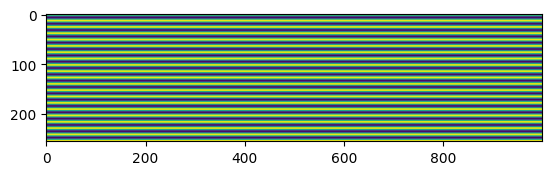

In [42]:
L = 100e-6
N = 256
Lz = 1000e-6
Nz = 1000

x = torch.linspace(-L/2, L/2, N)
z = torch.linspace(0, Lz, Nz)
wvl = 633e-9
k = torch.pi * 2 / wvl


X, Z = torch.meshgrid(x, z)

K = 5e-6
refractive_index = 0.05 * torch.cos(2 * torch.pi * X / K)
refractive_index_np = refractive_index.numpy()

plt.imshow(refractive_index)

## FROM ME

In [43]:
from scipy.fft import fft, fftfreq, fftshift
import math
from tqdm import tqdm

In [56]:
# reused from previous code

def angular_spectrum_propagation_range(U0, wvl, dx, dz, num_steps, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)
        
    return U_list


In [63]:
# Derived parameters
x_np = x.numpy()
dx = L / N
dz = Lz / Nz
k = 2 * np.pi / wvl
waist = 15e-6

angle_range_deg = np.linspace(-10, 10, 500)
angle_range_rad = np.deg2rad(angle_range_deg)


grating_phase = (2 * np.pi / wvl) * refractive_index_np * dz
phase_stack = np.exp(1j * grating_phase)

peak_intensities = []

for θ in tqdm(angle_range_rad):
    # 1D Gaussian beam tilted at angle θ
    U = np.exp(-(x_np**2) / waist**2) * np.exp(1j * k * x_np * np.sin(θ))

    for i in range(Nz):
        # Propagate only one step
        U = angular_spectrum_propagation_range(U[np.newaxis, :], wvl, dx, dz, 1, absorptive_boundary=True)[0][0]
        # Apply phase slice at depth z_i
        U *= phase_stack[:, i]

    # Fourier lens → 1D FFT
    U_fourier = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(U)))
    intensity = np.abs(U_fourier)**2
    peak_intensities.append(np.max(intensity))


100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


Simulated peak diffraction angle: 3.6273°
Theoretical Bragg angle (λK / 4π): 3.6292°


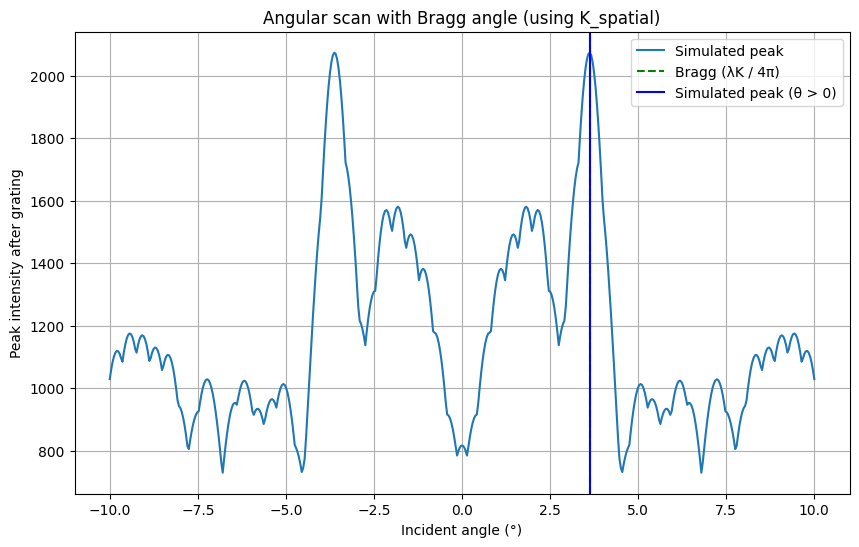

In [64]:
# mismath ch in the definition of K and Lambda
Lambda = K 
K_spatial = 2 * np.pi / Lambda 

bragg_angle = np.arcsin((wvl * K_spatial) / (4 * np.pi))  # sin(θ) = λK / (4π)



positive_indices = angle_range_rad > 0
positive_angles_deg = angle_range_deg[positive_indices]
positive_intensities = np.array(peak_intensities)[positive_indices]
max_idx_pos = np.argmax(positive_intensities)
max_angle_pos_deg = positive_angles_deg[max_idx_pos]

print(f"Simulated peak diffraction angle: {max_angle_pos_deg:.4f}°")
print(f"Theoretical Bragg angle (λK / 4π): {np.degrees(bragg_angle):.4f}°")

plt.figure(figsize=(10, 6))
plt.plot(angle_range_deg, peak_intensities, label='Simulated peak')
plt.axvline(np.degrees(bragg_angle), color='g', linestyle='--', label='Bragg (λK / 4π)')
plt.axvline(max_angle_pos_deg, color='b', linestyle='-', label='Simulated peak (θ > 0)')
plt.xlabel("Incident angle (°)")
plt.ylabel("Peak intensity after grating")
plt.title("Angular scan with Bragg angle (using K_spatial)")
plt.legend()
plt.grid()
plt.show()


The results found are very close to the theoretical ones, with only a difference of 0.002 degrees. Decreasing the angle step would lead to even better resolution.
THe graph is symetric, which is logical since we are using a cos function for the refractive index